# Tile-wise Image Convolution at Scale with TaskVine

This notebook shows how to filter a very large image by **splitting it into tiles
and sending each tile to remote TaskVine workers**.  
We keep the manager lightweight (no heavy math) while every worker:

1. receives one grayscale tile **plus** the desired 2-D kernel,  
2. performs the convolution by the classic **im2col × GEMM** trick, and  
3. streams the result back.

## Remote Function `apply_convolution`

The helper below is **serialized and shipped** to each worker.  It pads the tile, converts it to an “im2col” matrix without copies, runs a
single matrix multiply (**GEMM**), and reshapes back to the original grid.

In [1]:
def apply_convolution(tile_np, kernel_np):
    """
    Convolve a single grayscale *tile* with the given 2-D `kernel_np`
    using the classic “im2col × GEMM” trick.

    This function is sent to **remote TaskVine workers**.  The manager
    passes:
        tile_np   – NumPy array, shape (H, W)   one image tile
        kernel_np – NumPy array, shape (k, k)   e.g. 3×3 or 5×5 filter

    It returns an array of identical shape (H, W) with the filter applied.
    """
    import numpy as np

    k = kernel_np.shape[0]
    pad = k // 2

    # 1. Same-padding with reflection keeps edges crisp
    padded = np.pad(tile_np, pad, mode="reflect")

    # 2. Efficient im2col: each sliding window becomes one row
    H, W = tile_np.shape
    shape   = (H, W, k, k)
    strides = (
        padded.strides[0], padded.strides[1],  # move across image
        padded.strides[0], padded.strides[1],  # move inside kernel window
    )
    patches = np.lib.stride_tricks.as_strided(
        padded, shape=shape, strides=strides, writeable=False
    )
    col = patches.reshape(H * W, -1)  # (H·W, k²)

    # 3. Core compute: (H·W × k²)  @  (k² × 1)  →  (H·W × 1)
    # General Matrix Multiplications (GEMM)
    out_flat = col @ kernel_np.reshape(-1, 1)

    # 4. Back to image grid
    return out_flat.reshape(H, W)

## 3 · Manager: define kernels, submit tasks, stitch results

We pick an input image, a tile size, and a kernel name.  
The manager

* creates the tile tasks (`vine.PythonTask(apply_convolution, …)`),  
* waits for completion with progress bars, then  
* reassembles the full image and saves the high-resolution output.


In [2]:
import numpy as np

# ---- 3 × 3 kernels as NumPy arrays --------------------------------
KERNELS = {
    "sharpen": np.array([
        [ 0, -1,  0],
        [-1,  5, -1],
        [ 0, -1,  0],
    ], dtype=np.float32),

    "gaussian_blur": (1/16) * np.array([
        [1, 2, 1],
        [2, 4, 2],
        [1, 2, 1],
    ], dtype=np.float32),

    "edge_sobel": np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1],
    ], dtype=np.float32),
}

In [3]:
IMG_PATH   = "npp.jpg"
TILE_SIZE     = 256
SELECT_KERNEL =  "sharpen" # options - "sharpen" | "gaussian_blur" | "edge_sobel"

In [ ]:
import os

manager_name = api_key = os.environ.get("VINE_MANAGER_NAME")
print(f"Manager name: {manager_name}")

ports_str = os.environ.get("VINE_MANAGER_PORTS", "9123, 9150")
ports = [int(p.strip()) for p in ports_str.split(",")]
print(f"Manager Ports: {ports}")

Manager name: floability-efcff7a4-5a82-452a-85c7-84638264d751


In [ ]:
%%time
# ---- imports --------------------------------------------------------
import math, ndcctools.taskvine as vine
from pathlib import Path
from PIL import Image
from tqdm.notebook import tqdm


kernel = KERNELS[SELECT_KERNEL]

# ---- load image -----------------------------------------------------
orig_img_rgb = Image.open(IMG_PATH).convert("RGB")
img_gray = orig_img_rgb.convert("L")
img_gray_np     = np.asarray(img_gray, dtype=np.float32)
H, W         = img_gray_np.shape
tiles_x      = math.ceil(W / TILE_SIZE)
tiles_y      = math.ceil(H / TILE_SIZE)
total_tiles  = tiles_x * tiles_y
print(f"[load] {W}×{H}px → {total_tiles} tiles ({tiles_x}×{tiles_y})")

# ---- TaskVine manager ----------------------------------------------
m = vine.Manager(ports, name=manager_name)
print(f"[manager] Listening on port {m.port}")

task_map = {}
results  = [[None]*tiles_x for _ in range(tiles_y)]

# ---- submit tasks ---------------------------------------------------
print("[submit] queuing tasks …")
for iy in tqdm(range(tiles_y), desc="Submit rows"):
    for ix in range(tiles_x):
        y0, x0 = iy*TILE_SIZE, ix*TILE_SIZE
        y1, x1 = min(y0+TILE_SIZE, H), min(x0+TILE_SIZE, W)
        tile_np = img_gray_np[y0:y1, x0:x1].copy()
        tid = m.submit(vine.PythonTask(apply_convolution, tile_np, kernel))
        task_map[tid] = (ix, iy)
print("[submit] done")

# ---- collect results ------------------------------------------------
from tqdm.notebook import tqdm as tq
print("[collect] waiting …")
with tq(total=total_tiles, desc="Tiles done") as pbar:
    while not m.empty():
        t = m.wait(5)
        if not t:
            continue
        ix, iy = task_map[t.id]
        if t.successful():
            results[iy][ix] = t.output
            pbar.update(1)
        else:
            raise RuntimeError(f"tile ({ix},{iy}) failed: {t.result}")

# ---- stitch full image ---------------------------------------------
filtered = np.zeros_like(img_gray_np)
for iy in range(tiles_y):
    for ix in range(tiles_x):
        y0, x0 = iy*TILE_SIZE, ix*TILE_SIZE
        filtered[y0:y0+results[iy][ix].shape[0],
                 x0:x0+results[iy][ix].shape[1]] = results[iy][ix]

filtered_img = Image.fromarray(np.clip(filtered, 0, 255).astype("uint8"))
OUT_PATH = Path(IMG_PATH).with_stem(Path(IMG_PATH).stem + f"_{SELECT_KERNEL}")
filtered_img.save(OUT_PATH.with_suffix(".jpg"))
print(f"[output] saved '{OUT_PATH}.jpg'")

[load] 8000×8000px → 1024 tiles (32×32)
[manager] Listening on port 9123
[submit] queuing tasks …


Submit rows:   0%|          | 0/32 [00:00<?, ?it/s]

[submit] done
[collect] waiting …


Tiles done:   0%|          | 0/1024 [00:00<?, ?it/s]

[output] saved 'npp_sharpen.jpg.jpg'
CPU times: user 2.94 s, sys: 4.08 s, total: 7.02 s
Wall time: 58 s


## Results: quick side-by-side preview

We down-sample each image ( ≤ 1024 px on the long edge ) and display them
next to each other.  The full-resolution filtered file lives on disk.

In [6]:
# keep for preview
ORIGINAL_IMG  = img_gray
FILTERED_IMG  = filtered_img

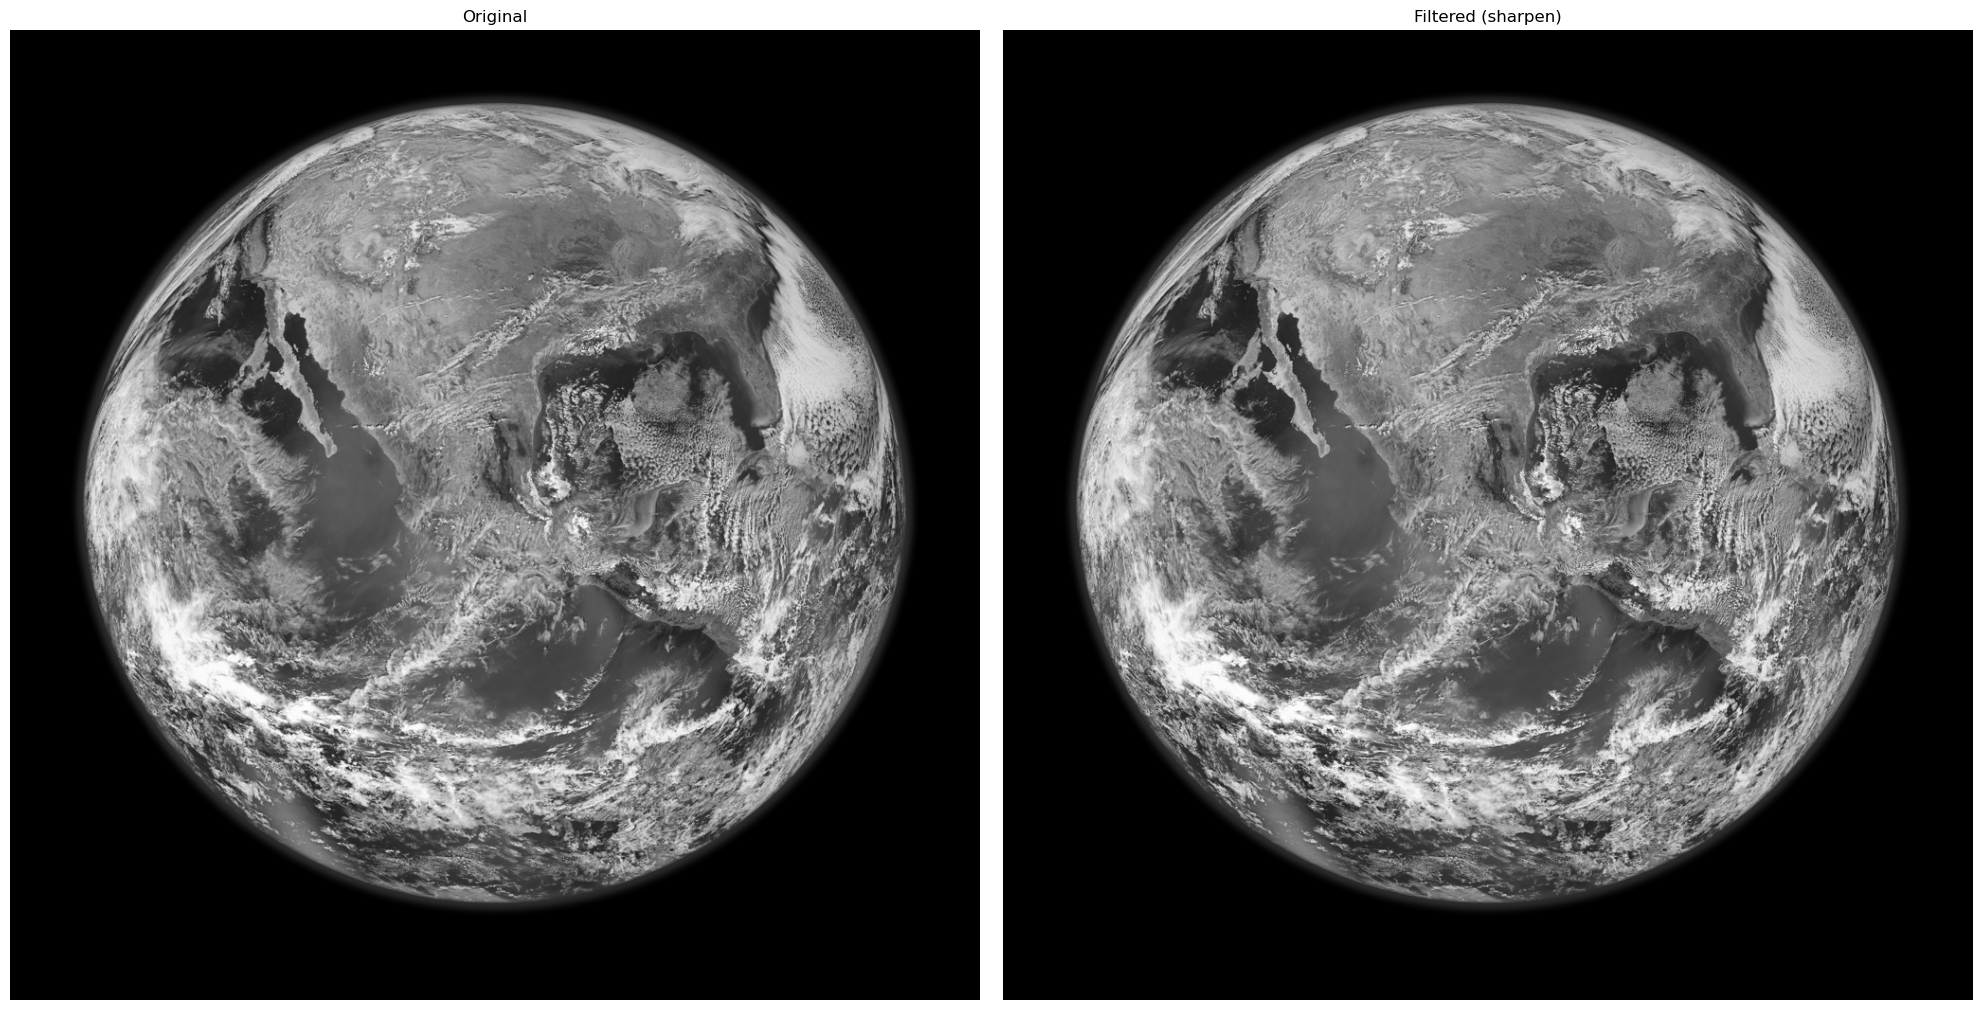

In [7]:
import matplotlib.pyplot as plt
from PIL import Image

def show_preview(pil_img: Image.Image, max_dim: int = 1024) -> Image.Image:
    """Return a down-sampled copy (≤ max_dim on the long edge)."""
    preview = pil_img.copy()
    preview.thumbnail((max_dim, max_dim))
    return preview

orig_preview  = show_preview(ORIGINAL_IMG)
filt_preview  = show_preview(FILTERED_IMG)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(orig_preview, cmap="gray")
ax[0].set_title("Original")
ax[0].axis("off")

ax[1].imshow(filt_preview, cmap="gray")
ax[1].set_title(f"Filtered ({SELECT_KERNEL})")
ax[1].axis("off")

plt.tight_layout()
plt.show()
